In [ ]:
import lightgbm as lgb
import pandas as pd
import math
import numpy as np
import random
import matplotlib.pyplot as plt

In [ ]:
# 使用データについて

from google.colab import drive
drive.mount('content.drive')

df_ana=pd.read_csv("/content/content.drive/MyDrive/Colab Notebooks/ANAホールディングス.csv", encoding="shift-jis")
print('Number of rows and columns:', df_ana.shape)
df_ana.head(5)

Mounted at content.drive
Number of rows and columns: (10219, 7)


,日付,始値,高値,安値,終値,出来高,調整後終値
0,2023/9/29,3179.0,3185.0,3115.0,3133.0,3613900,3133.0
1,2023/9/28,3244.0,3254.0,3130.0,3165.0,6311500,3165.0
2,2023/9/27,3250.0,3286.0,3239.0,3274.0,5288600,3274.0
3,2023/9/26,3290.0,3291.0,3263.0,3272.0,2245300,3272.0
4,2023/9/25,3269.0,3303.0,3268.0,3300.0,2397500,3300.0


In [ ]:
# ラベル名変更
df_ana = df_ana.rename(columns={'日付': 'Date', '始値': 'Open', '高値': 'High', '安値': 'Low', '終値': 'Close', '出来高': 'Turnover', '調整後終値': 'AdClose'})

df_ana["Date"] = pd.to_datetime(df_ana["Date"])
from datetime import datetime

# 並べ替え、番号振り直し
df_ana = df_ana.sort_values('Date', ascending=True)
df_ana = df_ana[(df_ana["Date"] > datetime(2010,12,31)) & (df_ana["Date"] < datetime(2023, 1, 4))]

# df_ana['Date'] = df_ana['Date'].astype(str)
# 並べ替え、番号振り直し
df_ana = df_ana.sort_values('Date', ascending=True)
df_ana = df_ana.reset_index(drop=True)

df_ana

,Date,Open,High,Low,Close,Turnover,AdClose
0,2011-01-04,307.0,307.0,305.0,307.0,4807000,3070.0
1,2011-01-05,307.0,309.0,304.0,305.0,6033000,3050.0
2,2011-01-06,306.0,307.0,303.0,305.0,5681000,3050.0
3,2011-01-07,306.0,307.0,304.0,306.0,6120000,3060.0
4,2011-01-11,305.0,306.0,304.0,305.0,3191000,3050.0
...,...,...,...,...,...,...,...
2930,2022-12-26,2809.0,2833.5,2804.0,2821.5,1229200,2821.5
2931,2022-12-27,2840.0,2904.5,2837.0,2862.5,3098300,2862.5
2932,2022-12-28,2853.0,2872.0,2819.0,2826.0,2353000,2826.0
2933,2022-12-29,2806.0,2815.5,2788.0,2798.5,2073100,2798.5


In [ ]:
df_ana_test = df_ana[(df_ana["Date"] > datetime(2020,12,31))]
df_ana_test

,Date,Open,High,Low,Close,Turnover,AdClose
2446,2021-01-04,2288.0,2288.0,2193.0,2232.0,4475700,2232.0
2447,2021-01-05,2198.5,2228.5,2188.0,2204.5,3233200,2204.5
2448,2021-01-06,2201.0,2209.5,2182.0,2199.0,4449100,2199.0
2449,2021-01-07,2223.0,2242.0,2189.0,2191.5,4094100,2191.5
2450,2021-01-08,2188.0,2191.5,2161.0,2184.0,4154100,2184.0
...,...,...,...,...,...,...,...
2930,2022-12-26,2809.0,2833.5,2804.0,2821.5,1229200,2821.5
2931,2022-12-27,2840.0,2904.5,2837.0,2862.5,3098300,2862.5
2932,2022-12-28,2853.0,2872.0,2819.0,2826.0,2353000,2826.0
2933,2022-12-29,2806.0,2815.5,2788.0,2798.5,2073100,2798.5


In [ ]:
sep = len(df_ana) - len(df_ana_test)
sep

2446

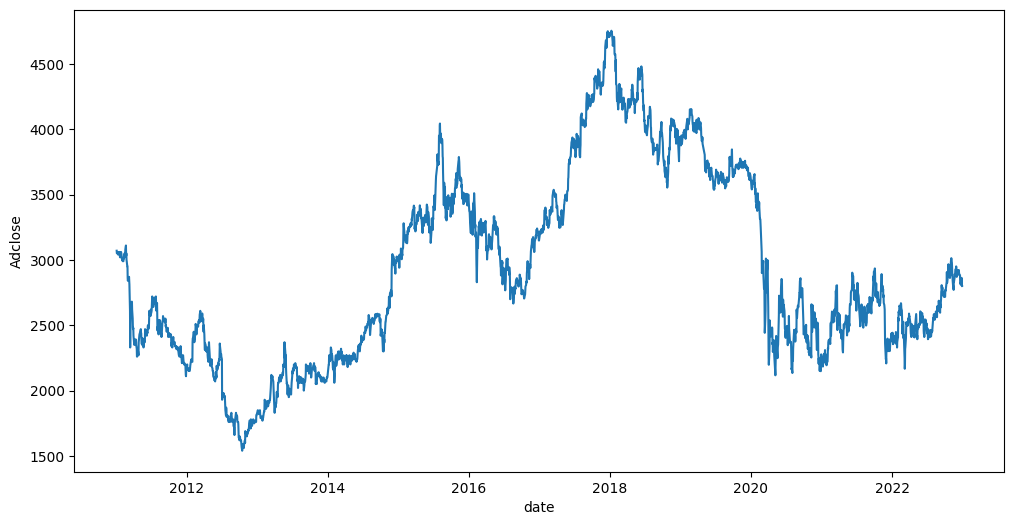

In [ ]:
# plt.title('Adjusted closing price Price History')
x = df_ana['Date']
y = df_ana["AdClose"]
plt.figure(figsize=(12,6))
plt.plot(x, y)
plt.xlabel('date')
plt.ylabel('Adclose')
plt.show()

In [ ]:
# 欠損値確認
df_ana.isnull().any()

Date        False
Open        False
High        False
Low         False
Close       False
Turnover    False
AdClose     False
dtype: bool

In [ ]:
# データ抽出
target_ana = df_ana['AdClose']
target_ana = np.array(target_ana).reshape(-1,1)
print(len(target_ana))

# training_data_len = math.ceil(len(target_ana)*0.7)
training_data_len = math.ceil(len(target_ana)*0.8)

# 訓練データ

# 予測期間
window_size = 20
predict_size=1
train_rate=0.8


ana_x = []
ana_y = []

for i in range(len(target_ana)-window_size-predict_size):
  ana_x.append(target_ana[i:i+window_size,0])
  ana_y.append(target_ana[i+window_size:i+window_size+predict_size,0])

train_rate = sep / int(np.shape(ana_x)[0])


tr_x_ana = ana_x[:int(np.shape(ana_x)[0]*train_rate)]
te_x_ana = ana_x[int(np.shape(ana_x)[0]*train_rate):]
tr_y_ana = ana_y[:int(np.shape(ana_y)[0]*train_rate)]
te_y_ana = ana_y[int(np.shape(ana_y)[0]*train_rate):]


print('tr_x_ana：',np.shape(tr_x_ana)[0])
print('te_x_ana：',np.shape(te_x_ana)[0])
print('tr_y_ana：',np.shape(tr_y_ana)[0])
print('te_y_ana：',np.shape(te_y_ana)[0])

2935
tr_x_ana： 2446
te_x_ana： 468
tr_y_ana： 2446
te_y_ana： 468


In [ ]:
# # numpy arrayに変換
tr_x_ana, tr_y_ana = np.array(tr_x_ana), np.array(tr_y_ana)
te_x_ana = np.array(te_x_ana)
te_y_ana = np.array(te_y_ana)

tr_y_ana = np.ravel(tr_y_ana)
te_y_ana = np.ravel(te_y_ana)

# グリッドサーチ

In [ ]:
# グリッドサーチによるハイパーパラメータ探索候補設定
# 今回はLightGBMのパラメータが対象(値は任意に設定)
parameters = {
    # 'n_estimators': [10, 20, 30],     # 用意する決定木モデルの数
    'learning_rate': (0.1,0.2,0.3),  # 学習率
    # 'num_leaves': (11,21,31), # 決定木にある最大ノード数
    'max_depth':   (6, 8, 10),     # 決定木のノード深さの制限値
    # 'early_stopping_round': (0,5,10),
    'colsample_bytree': (0, 0.2, 0.4, 0.6, 0.8, 1), #木を作成する際に使用する特徴量の数を選択する割合
    'min_child_weight': (1,3,5), # 決定木の葉の重みの下限
    'subsample': (0, 0.2, 0.4, 0.6, 0.8, 1), #使用するデータの選択割合
    # 'reg_alpha': (0.1, 0.2), #L1 正則化
    # 'reg_lamba': (0.1, 0.2), #L2 正則化
}



#モデルパラメータの設定と学習
# params = {'metric' : 'rmse'}
model = lgb.LGBMRegressor(random_state = 0)

# ハイパーパラメータチューニング(グリッドサーチのコンストラクタにモデルと辞書パラメータを指定)
from sklearn.model_selection import GridSearchCV
gridsearch = GridSearchCV(estimator = model,        # モデル
                          param_grid = parameters,  # チューニングするハイパーパラメータ
                          scoring = "neg_mean_squared_error",      # スコアリング
                          cv = 3 # 交差検証分割数
                         )

# 演算実行
gridsearch.fit(tr_x_ana, tr_y_ana)

ストリーミング出力は最後の 5000 行に切り捨てられました。
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-thread

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
891 fits failed out of a total of 2916.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
486 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py", line 1049, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py", line 842, in fit
    self._Booster = train(
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py", line 255, in train
    b

GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=0),
             param_grid={'colsample_bytree': (0, 0.2, 0.4, 0.6, 0.8, 1),
                         'learning_rate': (0.1, 0.2, 0.3),
                         'max_depth': (6, 8, 10), 'min_child_weight': (1, 3, 5),
                         'subsample': (0, 0.2, 0.4, 0.6, 0.8, 1)},
             scoring='neg_mean_squared_error')

In [ ]:
# グリッドサーチの結果から得られた最適なパラメータ候補を確認
print('Best params: {}'.format(gridsearch.best_params_))
print('Best Score: {}'.format(gridsearch.best_score_))

Best params: {'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.2}
Best Score: -28387.91030105083


# 学習

In [ ]:
lgb_ana = lgb.LGBMRegressor(n_estimators = 100, # 用意する決定木モデルの数
                                learning_rate = gridsearch.best_params_['learning_rate'], # 学習率
                               num_leaves = 31, # 決定木にある最大ノード数
                               max_depth    = gridsearch.best_params_['max_depth'],    # 決定木のノード深さの制限値
                               colsample_bytree = gridsearch.best_params_['colsample_bytree'], #木を作成する際に使用する特徴量の数を選択する割合
                               min_child_weight = gridsearch.best_params_['min_child_weight'], # 決定木の葉の重みの下限
                               subsample = gridsearch.best_params_['subsample'], #使用するデータの選択割合
                               random_state = 0,
                                )

lgb_ana.fit(tr_x_ana,tr_y_ana)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 2446, number of used features: 20
[LightGBM] [Info] Start training from score 2982.064800
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

LGBMRegressor(colsample_bytree=1, learning_rate=0.3, max_depth=6,
              min_child_weight=1, random_state=0, subsample=0.2)

In [ ]:
#予測の実行と書き出し
pred_ana = lgb_ana.predict(te_x_ana)
print(len(pred_ana))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
468


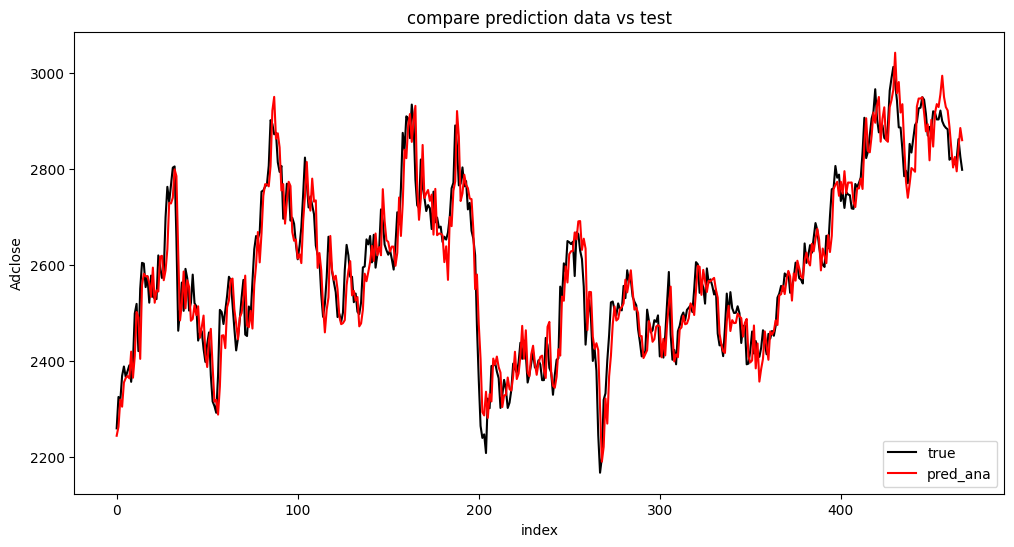

In [ ]:
x = [i for i in range(len(pred_ana))]
plt.figure(figsize=(12,6))
plt.title('compare prediction data vs test')
plt.plot(x,te_y_ana,color='black')
plt.plot(x,pred_ana,color='red')
plt.xlabel('index')
plt.ylabel('Adclose')
plt.legend(['true', 'pred_ana'], loc = 'lower right')
plt.show()

In [ ]:
from sklearn.metrics import r2_score            # 決定係数
from sklearn.metrics import mean_squared_error  # RMSE
from sklearn.metrics import mean_absolute_percentage_error # MAPE
# mean_squared_error(test_y, pred, squared=False)


# 平均平方二乗誤差(RMSE)
print('RMSE テスト: %.5f' % (
        # mean_squared_error(y_train, y_train_pred, squared=False), # 学習
        mean_squared_error(te_y_ana, pred_ana, squared=False)    # テスト
      ))
print('r2_score_ana(Closeのみ) テスト: %.5f' % (
        # mean_squared_error(y_train, y_train_pred, squared=False), # 学習
        r2_score(te_y_ana, pred_ana)    # テスト
      ))

print('MAPE_ana(Closeのみ) テスト: %.5f' % (
        # mean_squared_error(y_train, y_train_pred, squared=False), # 学習
        mean_absolute_percentage_error(te_y_ana, pred_ana)    # テスト
      ))

RMSE テスト: 53.40703
r2_score_ana(Closeのみ) テスト: 0.90576
MAPE_ana(Closeのみ) テスト: 0.01585


# 予測データ　出力


In [ ]:
pred_lightgbm = df_ana_test.drop(columns=['Open','High','Low','Close','Turnover'])
pred_lightgbm

,Date,AdClose
2446,2021-01-04,2232.0
2447,2021-01-05,2204.5
2448,2021-01-06,2199.0
2449,2021-01-07,2191.5
2450,2021-01-08,2184.0
...,...,...
2930,2022-12-26,2821.5
2931,2022-12-27,2862.5
2932,2022-12-28,2826.0
2933,2022-12-29,2798.5


In [ ]:
pred_lightgbm.index[1]
pred_lightgbm_dummy = pred_lightgbm
pred_lightgbm = pred_lightgbm
pred_lightgbm

,Date,AdClose
2446,2021-01-04,2232.0
2447,2021-01-05,2204.5
2448,2021-01-06,2199.0
2449,2021-01-07,2191.5
2450,2021-01-08,2184.0
...,...,...
2930,2022-12-26,2821.5
2931,2022-12-27,2862.5
2932,2022-12-28,2826.0
2933,2022-12-29,2798.5


In [ ]:
pred_lightgbm = pred_lightgbm.drop(range(2446,2467))
pred_lightgbm

,Date,AdClose
2467,2021-02-03,2325.0
2468,2021-02-04,2317.0
2469,2021-02-05,2369.0
2470,2021-02-08,2388.5
2471,2021-02-09,2366.5
...,...,...
2930,2022-12-26,2821.5
2931,2022-12-27,2862.5
2932,2022-12-28,2826.0
2933,2022-12-29,2798.5


In [ ]:
pred_lightgbm['pred_lightgbm'] = pred_ana
pred_lightgbm

,Date,AdClose,pred_lightgbm
2467,2021-02-03,2325.0,2244.033222
2468,2021-02-04,2317.0,2262.875865
2469,2021-02-05,2369.0,2319.474228
2470,2021-02-08,2388.5,2304.679272
2471,2021-02-09,2366.5,2355.036016
...,...,...,...
2930,2022-12-26,2821.5,2825.347395
2931,2022-12-27,2862.5,2795.303641
2932,2022-12-28,2826.0,2842.990849
2933,2022-12-29,2798.5,2885.589495


In [ ]:
pred_lightgbm.to_csv('/content/content.drive/MyDrive/Colab Notebooks/csv/ANA/20/lightgbm_ana20_20112022.csv')